In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils import data
import PIL
import numpy as np
from torch import nn
from torchinfo import summary
import torch.nn.functional as F
import time
from torch.autograd import Variable
from sklearn.metrics import f1_score
from torcheval.metrics.functional import multiclass_f1_score

In [2]:
path = 'Real'

dataset = ImageFolder(root=path)

# Print class names and their corresponding indices
class_names = dataset.classes
class_to_idx = dataset.class_to_idx
print("Class Names:", class_names)
print("Class to Index Mapping:", class_to_idx)
print("Total number of images:", len(dataset))

Class Names: ['nonviolence', 'violence']
Class to Index Mapping: {'nonviolence': 0, 'violence': 1}
Total number of images: 14056


In [3]:
import plotly.express as px

class_counts = [0] * len(class_names)
for _, label in dataset:
    class_counts[label] += 1



In [4]:
# Create a Plotly bar plot
fig = px.bar(x=class_names, y=class_counts, labels={'x': 'Class', 'y': 'Count'}, title='Class Distribution')
fig.update_xaxes(tickangle=-45)

fig.show()

In [5]:
gen = torch.Generator().manual_seed(42)
train_dataset, test_dataset = data.random_split(dataset, [0.8, 0.2], generator=gen)

In [6]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)
     

In [7]:
data_transforms = {
    'train': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    'test': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [8]:
train_dataset = MyDataset(train_dataset, transform=data_transforms['train'])  
test_dataset = MyDataset(test_dataset, transform=data_transforms['test'])

In [9]:
train_dataloader = data.DataLoader(train_dataset, batch_size=16, shuffle=True) 
test_dataloader = data.DataLoader(test_dataset, batch_size=16, shuffle=True) 


In [13]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
import matplotlib.pyplot as plt
def plot_examples(images, labels, rows=1):
    fig = plt.figure(figsize=(12, 6))
    columns = len(images) // (rows)
    for i, (img, lbl) in enumerate(zip(images, labels)):
        if i < columns*rows:
            input = img.numpy().transpose((1, 2, 0))   # Transpose it to get to original shape
            input = std * input + mean  # Unnormalising
            input = np.clip(input, 0, 1)
            ax = fig.add_subplot(rows, columns, i+1)   # Creating subplot for samples
            ax.imshow(input)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title("label: {}".format(class_names[lbl]))
    plt.tight_layout()
    return fig
     

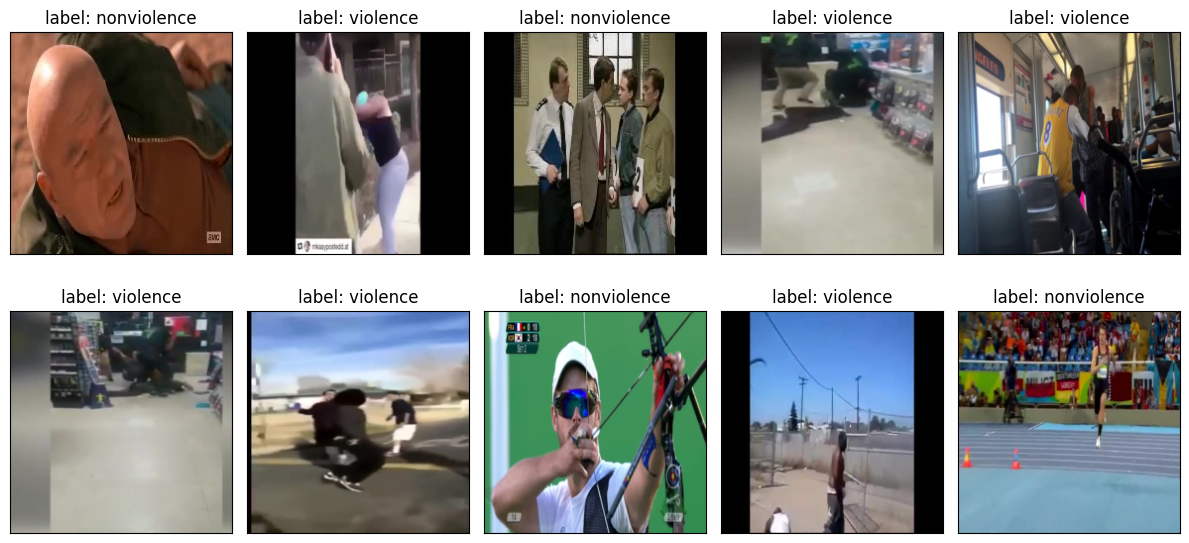

In [14]:
examples = enumerate(train_dataloader)
batch_idx, (images, labels) = next(examples)
images_=images[0:10]
labels_=labels[0:10]
plot_examples(images_, labels_, rows=2);

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [31]:
from models import NeuralNetwork

model = NeuralNetwork().to(device)

In [32]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
     

In [20]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [21]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
     

In [33]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")
     

Epoch 1
-------------------------------
loss: 0.706442  [   16/11245]
loss: 0.484224  [ 1616/11245]
loss: 0.510887  [ 3216/11245]
loss: 0.371632  [ 4816/11245]
loss: 0.649907  [ 6416/11245]
loss: 0.415178  [ 8016/11245]
loss: 0.307810  [ 9616/11245]
loss: 0.263529  [11216/11245]
Test Error: 
 Accuracy: 83.4%, Avg loss: 0.383863 

Epoch 2
-------------------------------
loss: 0.212250  [   16/11245]
loss: 0.413881  [ 1616/11245]
loss: 0.337452  [ 3216/11245]
loss: 0.214781  [ 4816/11245]
loss: 0.425586  [ 6416/11245]
loss: 0.409274  [ 8016/11245]
loss: 0.468277  [ 9616/11245]
loss: 0.158791  [11216/11245]
Test Error: 
 Accuracy: 88.5%, Avg loss: 0.292033 

Epoch 3
-------------------------------
loss: 0.254829  [   16/11245]
loss: 0.283633  [ 1616/11245]
loss: 0.072936  [ 3216/11245]
loss: 0.116684  [ 4816/11245]
loss: 0.330661  [ 6416/11245]
loss: 0.210316  [ 8016/11245]
loss: 0.230187  [ 9616/11245]
loss: 0.218333  [11216/11245]
Test Error: 
 Accuracy: 89.7%, Avg loss: 0.266661 

Epoc

In [35]:
torch.save(model.state_dict(), "model_weights.pth")

In [50]:
# Given a model and a dataloader, use classification_report
from sklearn.metrics import classification_report

def classification_rep(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(pred.argmax(1).cpu().numpy())
    return classification_report(y_true, y_pred, target_names=class_names)

print(classification_rep(model, test_dataloader))


              precision    recall  f1-score   support

 nonviolence       0.94      0.91      0.92      1384
    violence       0.92      0.94      0.93      1427

    accuracy                           0.93      2811
   macro avg       0.93      0.93      0.93      2811
weighted avg       0.93      0.93      0.93      2811



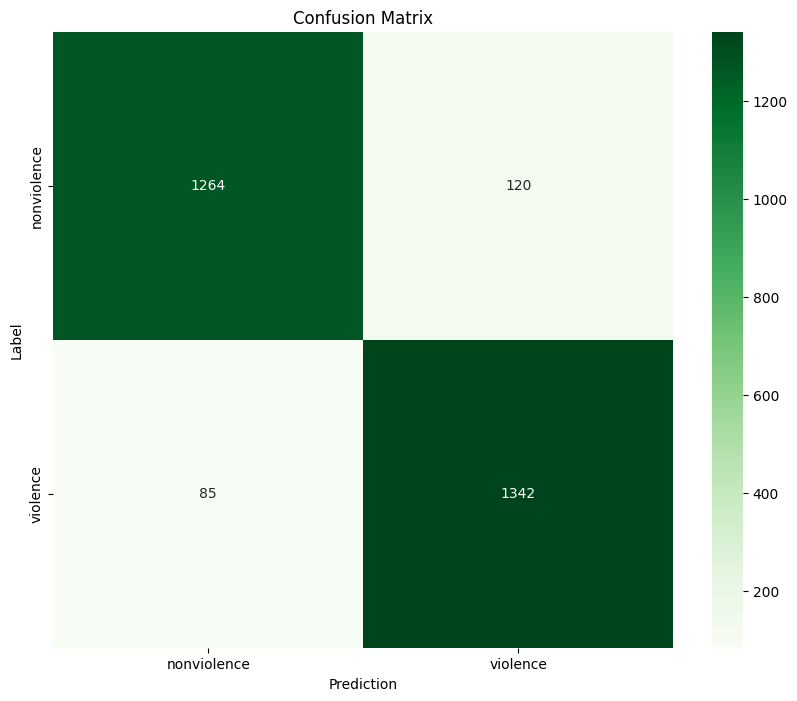

In [43]:
# Given a model and a dataloader, display heatmap
from sklearn.metrics import confusion_matrix
import seaborn as sns

def display_heatmap(model, dataloader):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            all_preds.append(pred.argmax(1))
            all_targets.append(y)
    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    cm = confusion_matrix(all_targets.cpu().numpy(), all_preds.cpu().numpy())
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.title('Confusion Matrix')
    plt.show()

display_heatmap(model, test_dataloader)

